# Introduction

La pratique de l'aviron en milieu naturel, comme sur les fleuves et rivières, dépend fortement des conditions hydrologiques telles que le débit, la température extérieure ou la hauteur d'eau. Ces paramètres jouent un rôle crucial dans la sécurité des rameurs, la qualité de l'expérience sportive, et l'organisation des entraînements et des compétitions. 

La Fédération Française d'Aviron a donc émis des lignes directrices de sécurité, dont les principes sont généralement appliqués au sein des clubs français : les sorties sur les plans d'eaux sont interdites lorsque le débit est trop puissant. Les variations du débit, souvent influencées par les conditions météorologiques (pluies, sécheresses), rendent leur prévision essentielle pour les clubs d'aviron et leurs pratiquants. Ce projet, centré sur la Seine, vise donc à développer un modèle de prédiction des conditions de bassin : il permettra d'anticiper les jours où les conditions sont optimales pour la pratique de l'aviron et à l'inverse les jours où les sorties seront trop dangereuses, en se fondant sur des données hydrométriques et météorologiques. Ce travail combine une analyse des données historiques et actuelles, et fournira la base d'un outil fiable et pratique pour faciliter la planification dans les clubs d'aviron en facilitant le respect des normes de sécurité de la pratique sportive.

Ce projet comprend 3 grandes parties : 
- Dans la première partie, nous importons les bases de données utiles
- Dans la deuxième partie, nous étudions et analysons les données recueillies pour préparer le modèle prédictif
- Dans la troisième partie, nous modélisons le problème pour tenter d'y apporter une réponse satisfaisante. Pour des questions de commodité et de rapidité d'exécution, nous avons choisi d'entraîner le modèle sur les données d'un peu plus d'un an (1er janvier 2023-30 novembre 2024).

NB : les fonctions ont été rassemblées dans des scripts et n'apparaissent pas directement dans ce notebook

# Sommaire
<!-- TOC maxdepth:5 -->
- [Introduction](#Introduction)
- [Sommaire](#Sommaire)
- [Environnement](#Environnement)
- [Data Loading](#1-data-loading)
  - [Bases de données météo horaire](#1-data-loading)
  - [Bases de données des clubs d'aviron](#1-data-loading)
  - [Clubs d'aviron et stations météorologiques et hydrologiques](#1-data-loading)
  - [Bases de données hydrométriques horaire (Archives)](#1-data-loading)
  - [Bases de données fluviales](#1-data-loading)
- [Data Analysis](#2-data-analysis)
  - [Représentation graphique](#21-représentation-graphique-des-fleuves-des-stations-météorologique-et-hydrométrique-et-des-clubs-daviron)
  - [Précipitations en fonction du temps](#22-graphe-des-précipitations-en-fonction-du-temps)
    - [Heure par heure](#22a-heure-par-heure)
    - [Par semaine](#22b-par-semaine)
  - [Températures en fonction du temps](#23-graphe-des-températures-en-fonction-du-temps)
    - [Heure par heure](#23a-heure-par-heure)
    - [Par semaine](#22b-par-semaine)
  - [Débit en fonction du temps](#24-graphe-du-débit-en-fonction-du-temps)
    - [Heure par heure](#24a-par-heure)
    - [Par semaine](#24b-par-semaine)
- [Data Modeling](#3-data-modeling)
  - [Création du dataframe complet de modélisation](#31-création-du-dataframe-complet-de-modélisation-de-la-situation)
  - [Etude approfondie de corrélation entre les variables](#32-etude-approfondie-de-corrélation-entre-les-variables)
  - [Création du modèle](#33-création-du-modèle)
  - [Prédiction](#34-prédiction)
- [Conclusion](#conclusion)
<!-- /TOC -->

# Environnement

In [167]:
!pip install cartopy
!pip install geopy
!pip install jupyter_contrib_nbextensions
!pip install --upgrade xgboost
!pip install --upgrade cffi

In [168]:
import os
import requests
from IPython.display import Markdown, display
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pandas as pd
import numpy as np

from datetime import datetime, timedelta
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from urllib.request import Request, urlopen

In [169]:
os.chdir("/home/onyxia/work/Projet-de-Python-Leroux-Gisserot") # pour l'emplacement
os.environ["PROJ_LIB"] = "/opt/conda/share/proj" # pour les projections sur carte

# 1. Data loading

Dans cette partie, nous importons :
- des bases de données météo horaire, classées par département (data.gouv.fr)
- des bases de données concernant les archives du débit de la Seine, pour chaque station hydrométrique d'intérêt
- une base de données permettant de tracer les cours d'eau sur une carte
- une base de données permettant de localiser les clubs d'aviron
- une base de données regroupant les informations des clubs d'aviron et des stations météorologique et hydrométriques les plus proches

In [170]:
#Importation des fonctions utiles pour cette partie
from utils.data_loading import (
    read_csv_from_url, 
    load_department_data,
    load_and_save_all_department_data,
    load_data_from_disk,
    load_data_from_disk_hydro,
    cleaning_and_organizing,
    get_coordinates,
    import_geojson_from_url,
    find_nearest_station,
    add_station_info_to_clubs,
)

---
### Bases de données météo horaire
Téléchargement depuis météo france / data.gouv.fr des bases de données météo, puis concaténation et nettoyage. Nous nous sommes concentrés sur les départements dans lesquels passe la Seine afin d'obtenir les données météo des localisations proches des clubs d'aviron de long de la Seine.

In [171]:
load_and_save_all_department_data(
    department_ids=["10", "27", "76", "77", "78", "91", "92", "95"], # départements par lesquels passe la Seine
    save_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24"
)

Loading data from internet and saving to disk: 100%|██████████| 8/8 [00:16<00:00,  2.09s/it]


In [172]:
meteo_horaire = load_data_from_disk(data_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-weather-23-24")

Loading and concatenating data from disk: 100%|██████████| 8/8 [00:00<00:00, 10.80it/s]


In [173]:
meteo_horaire = cleaning_and_organizing(
                                df=meteo_horaire,
                                columns=["DEPARTMENT_ID", "NOM_USUEL", "AAAAMMJJHH"],
                                date="AAAAMMJJHH"
                            )
                            
meteo_horaire                    

,DEPARTMENT_ID,NUM_POSTE,NOM_USUEL,LAT,LON,AAAAMMJJHH,RR1,T
0,10,10002001,AILLEVILLE_SAPC,48.254167,4.685667,2023-01-01 00:00:00,0.0,14.2
1,10,10002001,AILLEVILLE_SAPC,48.254167,4.685667,2023-01-01 01:00:00,0.0,14.3
2,10,10002001,AILLEVILLE_SAPC,48.254167,4.685667,2023-01-01 02:00:00,0.0,14.2
3,10,10002001,AILLEVILLE_SAPC,48.254167,4.685667,2023-01-01 03:00:00,0.0,14.3
4,10,10002001,AILLEVILLE_SAPC,48.254167,4.685667,2023-01-01 04:00:00,0.0,14.0
...,...,...,...,...,...,...,...,...
104851,95,95690001,WY-DIT,49.108167,1.830667,2024-12-28 23:00:00,0.0,0.8
104852,95,95690001,WY-DIT,49.108167,1.830667,2024-12-29 00:00:00,0.0,1.0
104853,95,95690001,WY-DIT,49.108167,1.830667,2024-12-29 01:00:00,0.0,1.1
104854,95,95690001,WY-DIT,49.108167,1.830667,2024-12-29 02:00:00,0.0,1.1


Le dataframe meteo_horaire contient les colonnes suivantes :
- DEPARTMENT_ID : le numéro du département où se trouve la station météo considérée
- NUM_POSTE : l'identifiant de la station météo
- NOM_USUEL : le nom de la station météo
- LAT et LON : les coordonnées de la station météo
- AAAAMMJJHH : la date exacte, à l'heure près, de la collecte d'information
- RR1 : les précipitations tombées en une heure (en millimètres)
- T : la température moyenne enregistrée pendant cette heure

On crée ensuite 2 dataframes différents:
- l'un nous servira pour entraîner le modèle (données recueillies entre le 1er janvier 2023 et le 30 novembre 2024) : meteo_horaire_train
- l'autre nous servira à faire des prédictions effectives (données recueillies sur les 30 derniers jours - durée maximale sur laquelle on dispose des données de débit en temps réel) : meteo_horaire_pred

In [174]:
date_limite = pd.to_datetime("2024-12-01 00:00:00")
meteo_horaire_train = meteo_horaire[meteo_horaire['AAAAMMJJHH'] < date_limite]

In [175]:
date_ajd = pd.to_datetime(datetime.now())
date_debut = date_ajd - timedelta(days=30)
meteo_horaire_pred = meteo_horaire[(meteo_horaire['AAAAMMJJHH'] > date_debut) & (meteo_horaire['AAAAMMJJHH'] <= date_ajd)]

---
### Base de données des clubs d'aviron et leur localisation

Création du dataset à partir des noms des clubs et de leurs adresses (récupérées sur FFaviron.fr) et association avec leurs coordonnées GPS correspondantes

In [176]:
clubs_aviron = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/adresses_clubs.csv', sep=';', header=0)

In [177]:
clubs_aviron[['LAT', 'LON']] = clubs_aviron['Adresse'].apply(get_coordinates)

---
### Informations sur les clubs d'avirons, et les stations météorologiques et hydrologiques les plus proches

Nous recensons les stations hydrométriques françaises grâce au dataset de l'Hydroportail hydro.eaufrance.fr, et le nettoyons de manière à ne garder que les colonnes d'intérêt pour les stations encore actives. On fait de même pour les stations météo, puis on merge les datasets afin d'obtenir un dataframe comprenant : les clubs d'aviron le long de la Seine, la station hydrométrique la plus proche sur la Seine (Nearest Hydro Station), la station météo la plus proche (Nearest Weather Station)

In [178]:
#Recensement des stations hydrométriques françaises
liste_stations_hydro = pd.read_csv('/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/liste-stations.csv', sep=';', header=0)
liste_stations_hydro = liste_stations_hydro.rename(columns={'cdentite': 'NUM_POSTE', 'lbstationhydro': 'NOM_USUEL', 'longitude': 'LON', 'latitude': 'LAT'})
liste_stations_hydro = liste_stations_hydro[~liste_stations_hydro["dtfermeture"].notna()] #Filtration des stations hydrométriques encore en activité
liste_stations_hydro = liste_stations_hydro.drop(['typestation', 'dtmiseservice', 'dtfermeture'], axis=1) #liste des stations françaises avec les colonnes d'intérêt
liste_stations_hydro

,NUM_POSTE,NOM_USUEL,LON,LAT
0,1011000101,[Barbotteau] à Petit-Bourg - Barbotteau,-61.658990,16.189402
4,1015000101,La rivière Bras David à Petit-Bourg [Maison Fo...,-61.693200,16.175998
5,1016000101,[Prise d'eau Duclos] à Petit-Bourg - Duclos,-61.666436,16.199137
10,1025000101,[La Boucan] à Sainte-Rose - BOUCAN,-61.668130,16.279712
12,1040000101,[Ravine Bleue] à Sainte-Rose - Ravbleue,-61.717770,16.293870
...,...,...,...,...
5758,Y970000201,U Cavu à Zonza - Parc aventures,9.301805,41.720263
5760,Y971000201,Le ruisseau de Palavesani à Porto-Vecchio,9.189782,41.661610
5762,Y980000202,Le ruisseau d'Orgone à Sotta - Pont RD 59,9.172844,41.556513
5764,Y980000302,Le Bala à Porto-Vecchio - Pont de Bala,9.237163,41.596406


In [179]:
#Ajout de la station météo la plus proche
stations_meteo_clubs = add_station_info_to_clubs(clubs_aviron, meteo_horaire, filter_keyboard=None)
stations_meteo_clubs = stations_meteo_clubs.rename(columns={'NUM_POSTE': 'NUM_NWS', 'NOM_USUEL': 'NWS'}) # NWS = Nearest Weather Station

#Ajout de la station hydrométrique la plus proche
stations_hydro_clubs = add_station_info_to_clubs(clubs_aviron, liste_stations_hydro, filter_keyboard='Seine') #Filtrer les stations prenant le débit de la Seine
stations_hydro_clubs = stations_hydro_clubs.rename(columns={'NUM_POSTE': 'NUM_NHS', 'NOM_USUEL': 'NHS'}) # NHS = Nearest Hydro Station

#Concaténation des dataframes.
clubs_hydro_meteo = pd.merge(stations_meteo_clubs, stations_hydro_clubs, on=["Club", "Adresse", "LAT", "LON"], how="inner")
clubs_hydro_meteo

,Club,Adresse,LAT,LON,NUM_NWS,NWS,NUM_NHS,NHS
0,Aviron Caudebec Vallée de Seine,9 route de Villequier 76490 Rives-en-Seine,49.523301,0.711545,76473001,NOTRE-DAME DE BLIQUETUIT,H512011001,La Seine à Caudebec-en-Caux
1,Cercle nautique de Canteleu-Croisset,46 Quai Gustave Flaubert 76380 Canteleu,49.432313,1.027671,76540009,ROUEN - JARDIN,H503011001,La Seine à Rouen
2,Club Nautique Et Athletique De Rouen,20 Rue de l'Industrie 76100 Rouen,49.435429,1.097776,76540009,ROUEN - JARDIN,H503011001,La Seine à Rouen
3,Club nautique de Belbeuf,8 Rte de Paris 76240 Belbeuf,49.370154,1.127481,76116001,ROUEN-BOOS,H501012001,La Seine à Oissel
4,Aviron Club Andelys-Tosny,Chemin de la Haguette 27700 Les Trois Lacs,49.229422,1.387091,27016001,LES ANDELYS,H320000104,La Seine à Vernon - Station débitmétrique (>2006)
5,Emulation Nautique de Vernon,Impasse de la Chaussée 27200 Vernon,49.097666,1.488373,27016001,LES ANDELYS,H320000104,La Seine à Vernon - Station débitmétrique (>2006)
6,Association sportive Mantaise,"Boulevard Sully, 78200 Mantes-la-Jolie",49.005172,1.682184,78354001,MAGNANVILLE,H308000101,La Seine à Limay [Mantes]
7,Aviron Meulan-les-Mureaux Hardricourt,15 Rue de Lorraine 78200 Mantes-la-Jolie,48.987197,1.713332,78354001,MAGNANVILLE,H308000101,La Seine à Limay [Mantes]
8,Aviron Club de Villennes-Poissy,Chemin des Pêcheurs 78670 Villennes-sur-Seine,48.931290,2.007438,78481001,LE PECQ,H300000201,La Seine à Poissy
9,Rowing Club de Port-Marly,12 Rue de Paris 78560 Le Port-Marly,48.880091,2.111393,78481001,LE PECQ,F712000102,La Seine à Chatou - Barrage (aval)


---
### Bases de données des archives hydrométriques

Nous cherchons à obtenir les datasets d'historique des débits d'écoulement de l'eau aux stations hydrométriques heure par heure sur la période 01/01/2023-30/11/2023 (pour construire le futur dataset d'entrainement du modèle). Ils doivent être récupérés à la main sur le site hydro.eaufrance.fr à cause du fonctionnement du site. C'est ce que nous faisons ici : 

In [180]:
#Récupération des codes d'identification des stations les plus proches clubs d'aviron
station_ids = clubs_hydro_meteo['NUM_NHS'].drop_duplicates().tolist()
resultat = "Les stations dont il faut récupérer les données dans les archives hydrométriques sont : " + ", ".join(station_ids)
display(Markdown(resultat))

Les stations dont il faut récupérer les données dans les archives hydrométriques sont : H512011001, H503011001, H501012001, H320000104, H308000101, H300000201, F712000102, F704000102, F704000101, F490000104, F449000601, F447000101, F400000301, H170001001, H080001101

On a donc téléchargé à la main les données des stations hydrométriques citées ci-dessus, et on les a placées dans le dossier hourly-flow-rate-23-24. Maintenant on les concatène, de manière à avoir un dataframe unique des débits aux stations hydrométriques considérées.

In [181]:
#Chargement des données et association du code (NUM_POSTE) de la station dont elles sont issues
debit_horaire = load_data_from_disk_hydro(data_dir="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/hourly-flow-rate-23-24")

#Normalisation du dataframe : Conversion de la date, suppression des colonnes inutiles, rename des colonnes
debit_horaire['Date (TU)'] = pd.to_datetime(debit_horaire['Date (TU)'], utc=True).dt.tz_localize(None) 
debit_horaire = debit_horaire.drop(['Statut', 'Qualification', 'Méthode', 'Continuité'], axis=1) 
debit_horaire = debit_horaire.rename(columns={'Date (TU)': 'AAAAMMJJHH', 'Valeur (en m³/s)': 'debit'}) 

#Ajout du nom de la station hydro correspondante au code
debit_horaire = debit_horaire.merge(liste_stations_hydro[['NUM_POSTE', 'NOM_USUEL']], on="NUM_POSTE", how="left")
debit_horaire



Loading and concatenating data from disk: 100%|██████████| 15/15 [00:00<00:00, 84.51it/s]


,AAAAMMJJHH,debit,NUM_POSTE,NOM_USUEL
0,2023-01-01 00:00:00,237.0,F490000104,La Seine à Alfortville - Station débitmétrique...
1,2023-01-01 01:00:00,238.0,F490000104,La Seine à Alfortville - Station débitmétrique...
2,2023-01-01 02:00:00,241.0,F490000104,La Seine à Alfortville - Station débitmétrique...
3,2023-01-01 03:00:00,233.0,F490000104,La Seine à Alfortville - Station débitmétrique...
4,2023-01-01 04:00:00,235.0,F490000104,La Seine à Alfortville - Station débitmétrique...
...,...,...,...,...
217785,2024-11-30 19:00:00,1062,H501012001,La Seine à Oissel
217786,2024-11-30 20:00:00,1064,H501012001,La Seine à Oissel
217787,2024-11-30 21:00:00,1058,H501012001,La Seine à Oissel
217788,2024-11-30 22:00:00,1057,H501012001,La Seine à Oissel


---
### Bases des données fluviales

Importation directe des données fluviales françaises depuis data.gouv.fr

In [182]:
rivers = import_geojson_from_url(
                geojson_url="https://www.data.gouv.fr/fr/datasets/r/f354a037-4a4e-4e7e-804b-01278ab228c5",
                geojson_file="/home/onyxia/work/Projet-de-Python-Leroux-Gisserot/data/rivers.geojson"
            )

# 2. Data analysis

In [183]:
#Importation des fonctions utiles pour cette partie
from utils.data_analysis import (
    carte_figures,
    trace_graphique,
    trace_graphique_multiple,
)

Cette partie vise à analyser les datasets que nous avons chargés, et à les mettre en perspective avec notre problématique de modélisation des variations du débit de la Seine. Nous commençons par une cartographie simple de notre cours d'eau d'étude :

#### 2.1. Représentation graphique des fleuves, des stations météorologique et hydrométrique, et des clubs d'aviron

In [184]:
# Récupération des coordonnées des stations meteo
coord_ws = pd.merge(clubs_hydro_meteo, meteo_horaire, left_on='NUM_NWS', right_on='NUM_POSTE', how="inner")
coord_ws = coord_ws[["NUM_NWS", "NWS", "LAT_y", "LON_y"]].drop_duplicates()
coord_ws = coord_ws.rename(columns={'LAT_y': 'LAT', 'LON_y': 'LON'})

In [185]:
# Récupération des coordonnées des sttaions hydrométriques
coord_hs = pd.merge(clubs_hydro_meteo, liste_stations_hydro, left_on='NUM_NHS', right_on='NUM_POSTE', how="inner")
coord_hs = coord_hs[["NUM_NHS", "NHS", "LAT_y", "LON_y"]].drop_duplicates()
coord_hs = coord_hs.rename(columns={'LAT_y': 'LAT', 'LON_y': 'LON'})

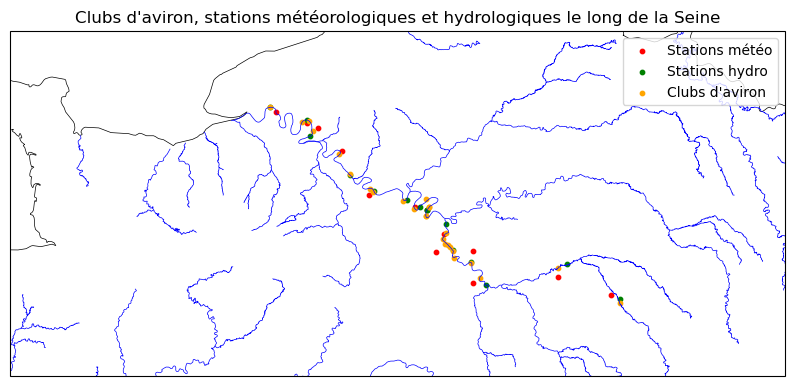

In [186]:
# Tracé du graphique
carte_figures(rivers, coord_ws, coord_hs, clubs_aviron)

---

On centre maintenant notre analyse sur un club d'aviron précis, l'Emulation nautique de Vernon, afin d'analyser les données que l'on a sur son bassin de pratique. Nous cherchons à tracer différents graphiques  (les précipitations, la température ou encore le débit en fonction du temps) pour tenter de remarquer des tendances ou des corrélations entres les variables. 

In [187]:
nom_club = 'Emulation Nautique de Vernon'
nws = clubs_hydro_meteo.loc[clubs_hydro_meteo['Club'] == nom_club, 'NWS'].iloc[0]
nhs = clubs_hydro_meteo.loc[clubs_hydro_meteo['Club'] == nom_club, 'NHS'].iloc[0]
nws_nhs = f'La station météo la plus proche du club {nom_club} est {nws} et la station hydrométrique la plus proche est {nhs}'
display(Markdown(nws_nhs))

La station météo la plus proche du club Emulation Nautique de Vernon est LES ANDELYS et la station hydrométrique la plus proche est La Seine à Vernon - Station débitmétrique (>2006)

#### 2.2 Graphe des précipitations en fonction du temps

##### 2.2.a. <u>Heure par heure</u>

In [188]:
#Création d'une copie du dataframe avec uniquement les précipitations et la température proches du club considéré
meteo_nws = meteo_horaire[meteo_horaire["NOM_USUEL"] == nws].copy()
meteo_nws = meteo_nws.dropna(subset=['RR1', 'T'])

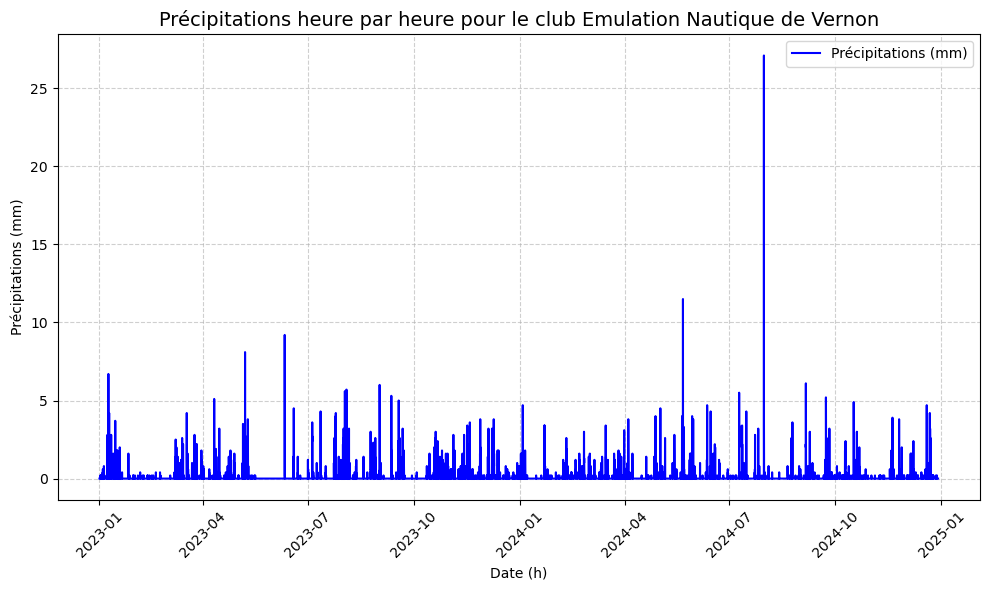

In [189]:
trace_graphique(
    x=meteo_nws["AAAAMMJJHH"],
    y=meteo_nws["RR1"],
    titre=f"Précipitations heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Précipitations (mm)",
)

Ce graphique détaille les précipitations enregistrées **heure par heure**. Il met en évidence la nature très variable des précipitations, avec de nombreux pics irréguliers.  
- Les pics isolés témoignent de périodes courtes mais **intenses de précipitation**.  
- Entre ces pics, les précipitations sont souvent nulles ou très faibles.  

Cette granularité **horaire**, utile pour analyser la variabilité des précipitations à court terme, rend difficile la lecture des **tendances globales** à cause de l'apparente saturation de l'information.

Pour un modèle de prévision du débit, ces données brutes heure par heure peuvent donc être **trop détaillées** pour être directement exploitées. En effet, les débits d'un cours d'eau dépendent davantage de cumuls de précipitations sur des périodes plus longues (journées ou semaines) que d'événements ponctuels. Typiquement, de grosses averses (juillet-août 2024) sont plus plus susceptibles d'impacter le débit de la Seine que des pluies isolées, c'est ce qu'il serait intéressant d'étudier.

##### 2.2.b. <u>Par semaine</u>

In [190]:
# On crée un nouveau dataframe où les précipitations sont sommées par semaine
meteo_nws['hebdo'] = meteo_nws['AAAAMMJJHH'].dt.to_period('W')
precipit_hebdo = meteo_nws.groupby('hebdo', as_index=False)['RR1'].sum()
precipit_hebdo['hebdo'] = precipit_hebdo['hebdo'].dt.to_timestamp(how='start')

# Puis on fait une moyenne glissante sur 3 semaines pour lisser la courbe
precipit_hebdo['moy_gliss'] = precipit_hebdo['RR1'].rolling(window=3, min_periods=1, center=True).mean()

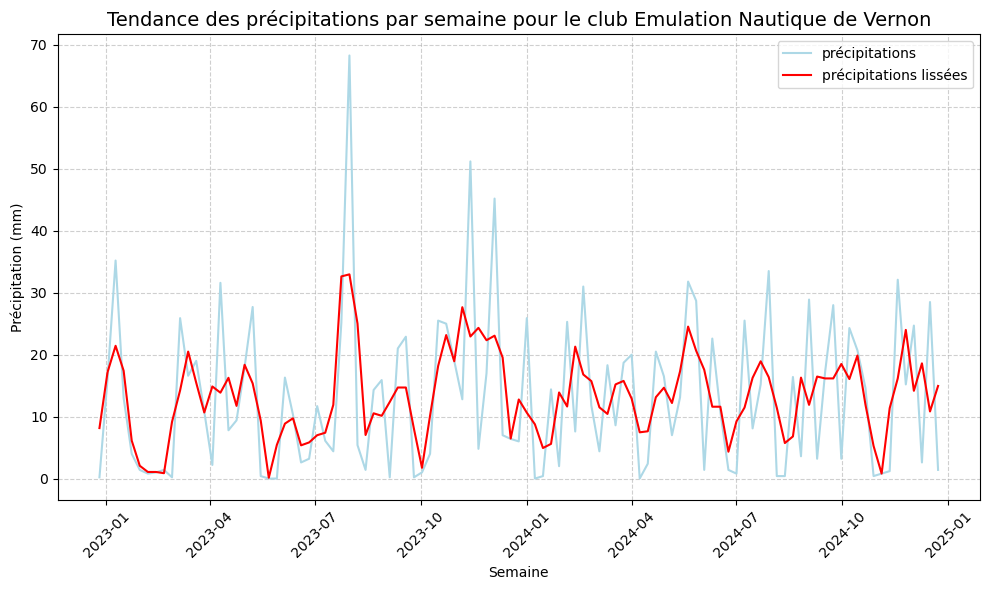

In [191]:
# Préparation des données pour la fonction
y_dico1 = {
    "précipitations": {"y": precipit_hebdo["RR1"], "color": "lightblue", "linestyle": "-"},
    "précipitations lissées": {"y": precipit_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=precipit_hebdo["hebdo"],
    y_mult=y_dico1,
    titre=f'Tendance des précipitations par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Précipitation (mm)",
)

Ce graphique agrège les précipitations à une échelle **hebdomadaire**, ce qui permet de mieux identifier les **tendances globales** dans les précipitations :  
- En bleu clair : la somme hebdomadaire des précipitations montre les fluctuations globales des précipitations au fil du temps.  
- En rouge : la moyenne glissante sur 3 semaines lisse les variations hebdomadaires, révélant les tendances de fond sans être perturbée par des oscillations trop rapides.

Ce lissage est particulièrement utile pour **détecter les périodes humides ou sèches prolongées**, qui influencent directement le débit des cours d'eau. On observe plusieurs pics significatifs sur l'année 2023 (notamment au printemps et en automne), ce qui est cohérent avec les périodes de précipitations accrues.  

Les **sommations hebdomadaires** permettent de mieux **relier les précipitations aux variations de débit**, car elles intègrent une échelle temporelle plus pertinente pour l'évolution du niveau d'eau. La **moyenne glissante** aide à anticiper les périodes où les cours d'eau risquent d'atteindre des niveaux élevés, en réponse à des cumuls prolongés.

---

Pour **prédire le débit d'un cours d'eau**, il serait pertinent d'utiliser les données hebdomadaires comme **variable explicative principale**, en intégrant les tendances de fond issues de la moyenne glissante pour améliorer les prédictions.

---

#### 2.3. Graphe des températures en fonction du temps
##### 2.3.a. <u>Heure par heure</u>

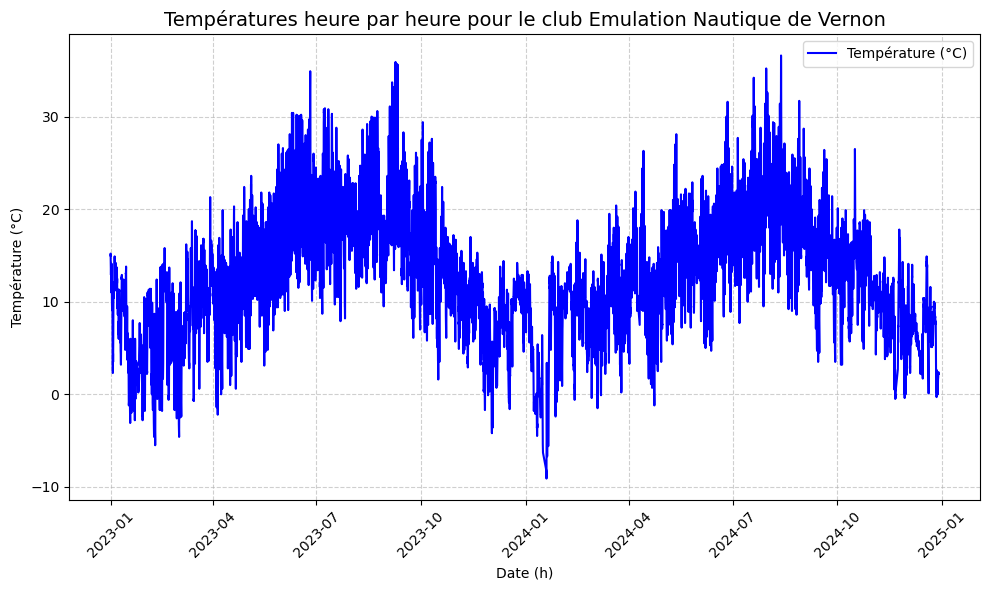

In [192]:
trace_graphique(
    x=meteo_nws["AAAAMMJJHH"],
    y=meteo_nws["T"],
    titre=f"Températures heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Température (°C)",
)

Ce graphique montre l'évolution de la température en fonction du temps à une résolution horaire. Il met à la fois en évidence les tendances globales de température en fonction des saisons (20-25°C vers juillet-août aussi bien en 2023 qu'en 2024, autour de 5°C en janvier-février) et la variabilité journalière des températures. Plusieurs phénomènes sont à analyser ici : d'abord la **saisonnalité temporelle** : les températures influencent l'évaporation et la fonte des neiges, ce qui peut expliquer un impact potentiel sur le débit des cours d'eau. Ensuite, la **variabilité horaire** est assez importante : cette variabilité peut être liée à des événements météorologiques locaux (comme des fronts froids ou chauds) qui affectent aussi les précipitations et, par extension, les débits des rivières.

En conclusion : les températures, combinées aux précipitations, doivent logiquement influencer directement le débit par la fonte des neiges, l'infiltration dans les sols, et l'évaporation. Ces variations saisonnières et horaires de température doivent donc être intégrées comme une variable explicative dans le modèle de prédiction.

##### 2.3.b. <u>Par semaine</u>

In [193]:
# On reproduit la même méthode que pour les précipitations
temp_hebdo = meteo_nws.groupby('hebdo', as_index=False)['T'].mean()
temp_hebdo['hebdo'] = temp_hebdo['hebdo'].dt.to_timestamp(how='start')
temp_hebdo['moy_gliss'] = temp_hebdo['T'].rolling(window=3, min_periods=1, center=True).mean()

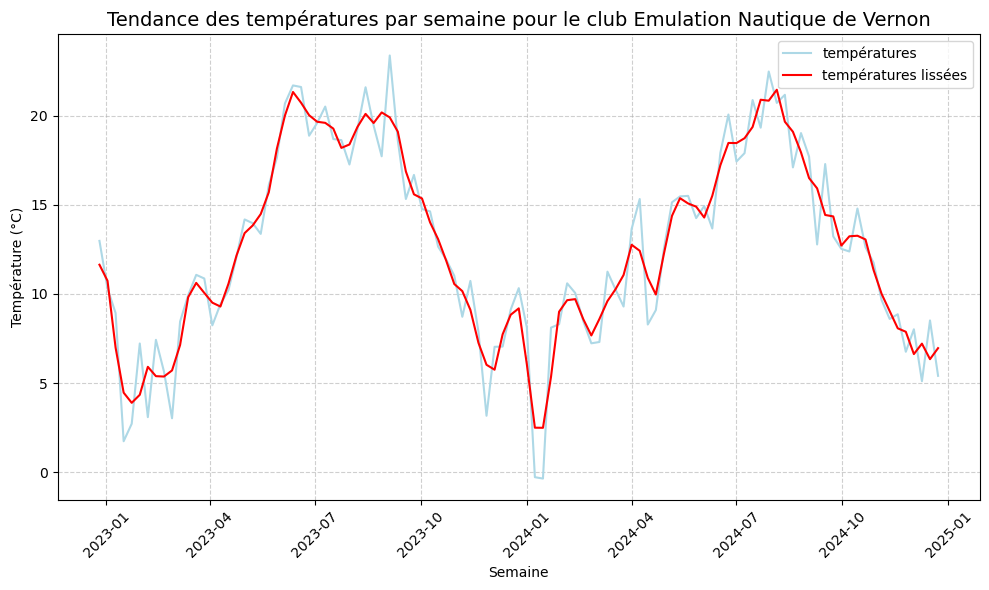

In [194]:
# Préparation des données pour la fonction
y_dico2 = {
    "températures": {"y": temp_hebdo["T"], "color": "lightblue", "linestyle": "-"},
    "températures lissées": {"y": temp_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

# Appel de la fonction
trace_graphique_multiple(
    x=temp_hebdo["hebdo"],
    y_mult=y_dico2,
    titre=f'Tendance des températures par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Température (°C)",
)

Ici, on se restreint à la compréhension des tendances globales de températures. Cette restriction ne permet pas de voir de corrélation directe avec les précipitations. Les températures et les précipitations jouent donc probablement leur rôle dans la prédiction du débit des cours d'eau de manière indépendante.

Mais on peut d'ores-et-déjà émettre quelques hypothèses : 
- plus les précipitations sont importantes et plus elles durent longtemps, plus le débit sera élevé, ceteris paribus
- plus la température est élevée et plus la période de chaleur est longue, plus le débit sera faible, ceteris paribus
- plus la température est élevée, plus les précipitations ont un impact positif sur le débit (par ruissellement)

----
Mettons maintenant ces informations en perspective avec le données liées au débit. Ces variations conditionnent la pratique de l'aviron : au-dessus d'un certain seuil, il devient trop dangereux de sortir sur l'eau en bateau.

#### 2.4. Graphe du débit en fonction du temps
##### 2.4.a. <u>Par heure</u>

In [195]:
#Création d'une copie du dataframe avec uniquement le débit capté au plus proche du club d'aviron considéré
debit_nhs = debit_horaire[debit_horaire["NOM_USUEL"] == nhs].copy()
debit_nhs = debit_nhs.dropna(subset='debit')

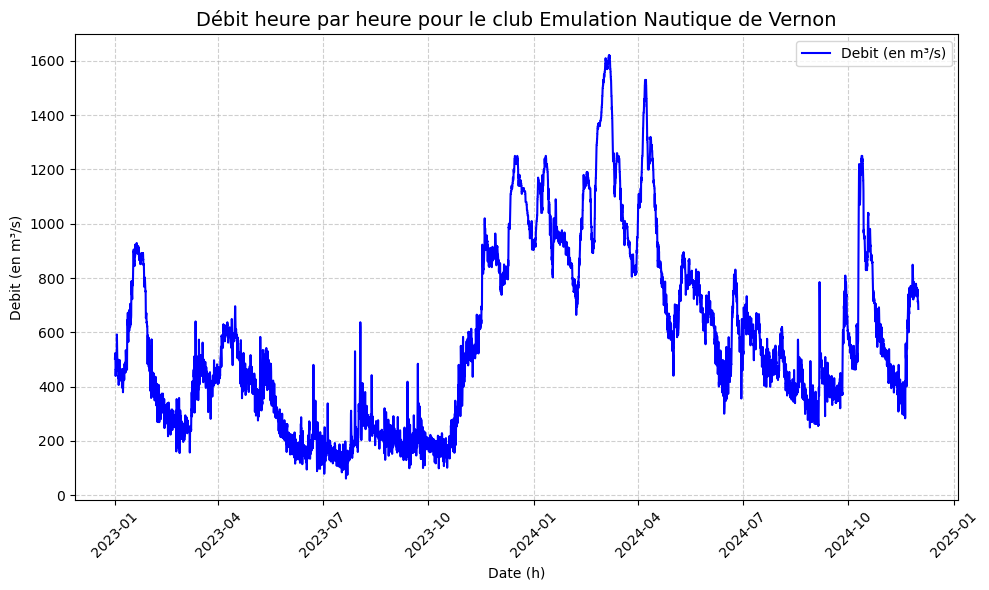

In [196]:
trace_graphique(
    x=debit_nhs["AAAAMMJJHH"],
    y=debit_nhs["debit"],
    titre=f"Débit heure par heure pour le club {nom_club}",
    xlabel="Date (h)",
    ylabel="Debit (en m³/s)",
)

De même que pour les autres variables, on observe des variations saisonnières marquées avec des pics de débit plus élevés au début de chaque année (notamment en hiver/printemps) et des périodes de débits plus faibles en été. Les variations sont relativement "brutales" lorsqu'elles surviennent, à contrario de la température où les écarts sont plus lissés.

##### 2.4.b. <u>Par semaine</u>

In [197]:
# On reproduit la même méthode que pour les précipitations
debit_nhs['hebdo'] = debit_nhs['AAAAMMJJHH'].dt.to_period('W')
debit_hebdo = debit_nhs.groupby('hebdo', as_index=False)['debit'].mean()
debit_hebdo['hebdo'] = debit_hebdo['hebdo'].dt.to_timestamp(how='start')
debit_hebdo['moy_gliss'] = debit_hebdo['debit'].rolling(window=3, min_periods=1, center=True).mean()

In [198]:
# Préparation des données pour la fonction
y_dico2 = {
    "débit": {"y": debit_hebdo["debit"], "color": "lightblue", "linestyle": "-"},
    "débit lissé": {"y": debit_hebdo["moy_gliss"], "color": "red", "linestyle": "-"}
}

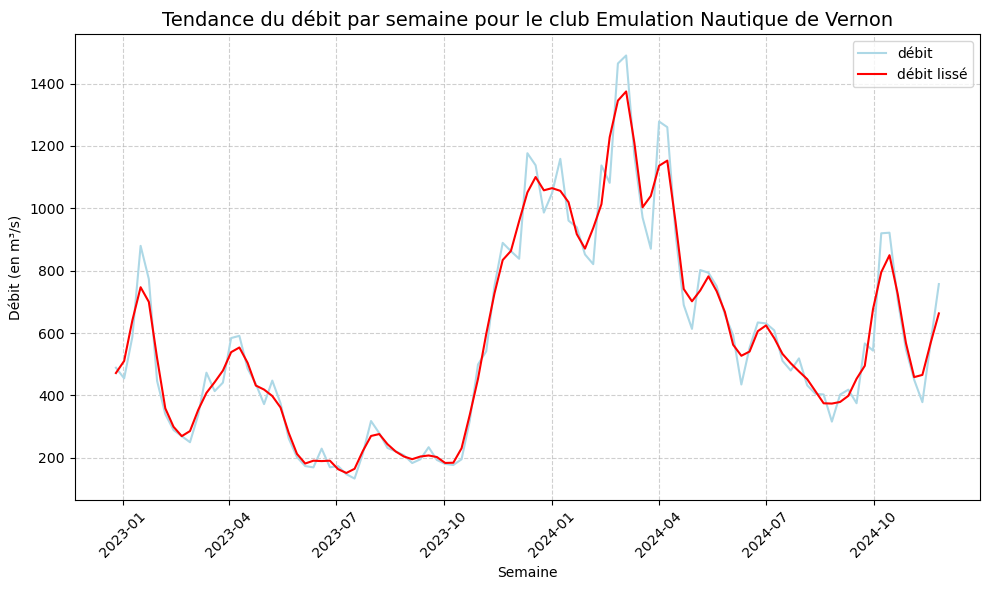

In [199]:
# Appel de la fonction
trace_graphique_multiple(
    x=debit_hebdo["hebdo"],
    y_mult=y_dico2,
    titre=f'Tendance du débit par semaine pour le club {nom_club}',
    xlabel="Semaine",
    ylabel="Débit (en m³/s)",
)

Ce lissage met en évidence la tendance générale, en réduisant les variations hebdomadaires causées par des fluctuations très irrégulières (crues soudaines).
Ce débit lissé suit la dynamique globale du débit réel mais élimine les pics et creux extrêmes, et permet de mieux voir les variations saisonnières. Par exemple, les hausses marquées du début de l’année (hiver/printemps) et les baisses durant l’été sont clairement visibles et plus facilement interprétables.

# **3. Data modeling**

In [200]:
#Importation des fonctions utilisées dans cette partie
from utils.data_modeling import (
    correlation1,
    correlation2,
    plot_correlations,
    create_features,
)

from utils.data_analysis import (trace_graphique)

## 3.1 Création du dataframe complet de modélisation de la situation

On cherche à iobtenir un datagframe généraliste, regroupant toutes les données d'intérêt pré-chargées dans la partie data loading. C'est sur ce dataframe, regroupant toutes les donnée horaires par club d'aviron du 1 janvier 2023 au 30 novembre 2024 que nous entrainerons le modèle de prédiction.

In [201]:
#1: on joint les données horaires hydrométriques avec celles des clubs,stations hydros et stations météo sur NUM_NHS
debit_club = debit_horaire.merge(
    clubs_hydro_meteo[['Club', 'LAT', 'LON', 'NUM_NHS', 'NHS']],
    left_on='NUM_POSTE',
    right_on='NUM_NHS',
    how='inner'
)

In [202]:
# 2: on joint les données horaires météo avec avec celles des clubs,stations hydros et stations météo sur NUM_NWS
meteo_club = meteo_horaire_train.merge(
    clubs_hydro_meteo[['Club', 'LAT', 'LON', 'NUM_NWS', 'NWS']],
    left_on='NUM_POSTE',
    right_on='NUM_NWS',
    how='inner'
)

In [203]:
# 3: on combine les deux DataFrames sur le Club et la colonne temporelle 'AAAAMJJHH'
combined = debit_club.merge(
    meteo_club,
    on=['Club', 'AAAAMMJJHH'],
    suffixes=('_hydro', '_meteo')
)

In [204]:
# 4: on sélectionne les colonnes pertinentes et on copie le dataframe pour éviter les intéractions fâcheuses
result = combined[['Club', 'LAT', 'LON', 'NHS', 'NWS', 'AAAAMMJJHH', 'debit', 'RR1', 'T']].copy()

# Et on normalise le dataframe afin de le rendre prêt pour la modélisation
# On s'assure que toutes les valeurs sont numériques
result["debit"] = pd.to_numeric(result["debit"], errors="coerce")
result["LAT"] = pd.to_numeric(result["LAT"], errors="coerce")
result["LON"] = pd.to_numeric(result["LON"], errors="coerce")
result = result.dropna(subset=["debit", "RR1", "T"])

# Suppression les colonnes inutiles pour la prédiction
result = result.drop(columns=["NWS", "NHS"])

# Extraction les caractéristiques temporelles 
result["année"] = result["AAAAMMJJHH"].dt.year
result["mois"] = result["AAAAMMJJHH"].dt.month
result["jour"] = result["AAAAMMJJHH"].dt.day
result["heure"] = result["AAAAMMJJHH"].dt.hour

# Supprimer la colonne datetime originale si elle n'est plus utile
result = result.drop(columns=["AAAAMMJJHH"])
result


,Club,LAT,LON,debit,RR1,T,année,mois,jour,heure
0,Club Nautique d'Ablon-sur-Seine,48.723354,2.422538,237.0,0.0,14.2,2023,1,1,0
1,Société Nautique de la Haute Seine,48.687161,2.388400,237.0,0.0,14.2,2023,1,1,0
2,Club Nautique d'Ablon-sur-Seine,48.723354,2.422538,238.0,0.0,14.4,2023,1,1,1
3,Société Nautique de la Haute Seine,48.687161,2.388400,238.0,0.0,14.4,2023,1,1,1
4,Club Nautique d'Ablon-sur-Seine,48.723354,2.422538,241.0,0.0,14.4,2023,1,1,2
...,...,...,...,...,...,...,...,...,...,...
386965,Club nautique de Belbeuf,49.370154,1.127481,1062.0,0.0,5.9,2024,11,30,19
386966,Club nautique de Belbeuf,49.370154,1.127481,1064.0,0.0,6.6,2024,11,30,20
386967,Club nautique de Belbeuf,49.370154,1.127481,1058.0,0.0,6.5,2024,11,30,21
386968,Club nautique de Belbeuf,49.370154,1.127481,1057.0,0.0,6.4,2024,11,30,22


## 3.2 Etude approfondie de corrélation entre les variables


In [205]:
# Corrélation entre le débit et les précipitations aux heures précédentes
correlation1(result, "RR1", 1, 26, 6)


Corrélation avec RR1 décalé de 1 heure(s) : 0.019033222882833142
Corrélation avec RR1 décalé de 7 heure(s) : 0.019786503544151988
Corrélation avec RR1 décalé de 13 heure(s) : 0.016991218137097856
Corrélation avec RR1 décalé de 19 heure(s) : 0.01613452590861509
Corrélation avec RR1 décalé de 25 heure(s) : 0.015942366329922505


Les résultats montrent une très faible corrélation entre le débit et les précipitations aux heures précédentes, avec des coefficients proches de zéro, quelle que soit la période de décalage (1 à 25 heures). Cela suggère que les précipitations récentes ont peu ou pas d'impact direct et immédiat sur le débit mesuré.

In [206]:
# Corrélation entre le débit et la température aux heures précédentes
correlation1(result, "T", 1, 26, 6)

Corrélation avec T décalé de 1 heure(s) : -0.18827794168084638
Corrélation avec T décalé de 7 heure(s) : -0.18918181509808882
Corrélation avec T décalé de 13 heure(s) : -0.18942340355426543
Corrélation avec T décalé de 19 heure(s) : -0.18894937749562213
Corrélation avec T décalé de 25 heure(s) : -0.18887775902169363


Les résultats montrent une corrélation négative faible entre le débit et la température, avec des valeurs autour de -0,19 pour tous les décalages. Cela signifie que la température a un effet légèrement inverse sur le débit, mais l’impact reste limité.

In [207]:
# Corrélation entre le débit et le débit aux heures précédentes
correlation1(result, "debit", 1, 26, 6)


Corrélation avec debit décalé de 1 heure(s) : 0.9973595401277805
Corrélation avec debit décalé de 7 heure(s) : 0.9841829947744226
Corrélation avec debit décalé de 13 heure(s) : 0.9775895237618785
Corrélation avec debit décalé de 19 heure(s) : 0.9747035502011074
Corrélation avec debit décalé de 25 heure(s) : 0.9731472410676353


Il vient sans surprise que le débit à l'heure h est très corrélé (coefficient quasiment égal à 1) au débit aux heures h-1, h-2, etc. Inversement, celui-ci semble plutôt indépendant (coefficient faible voire presque nul) des précipitations ou des changements de température récents. 

Cependant disposer du débit de l'heure précédente n'est pas forcément très réaliste dans une optique de prédiction du débit d'un jour sur l'autre par exemple. On peut donc se concentrer sur l'étude de corrélation entre le débit et la moyenne des températures sur les derniers jours, ou entre le débit et la somme des précipitations sur les derniers jours.

Nous cherchons à savoir à combien de jours il serait le plus efficace de remonter pour prédire le débit des jours à venir.

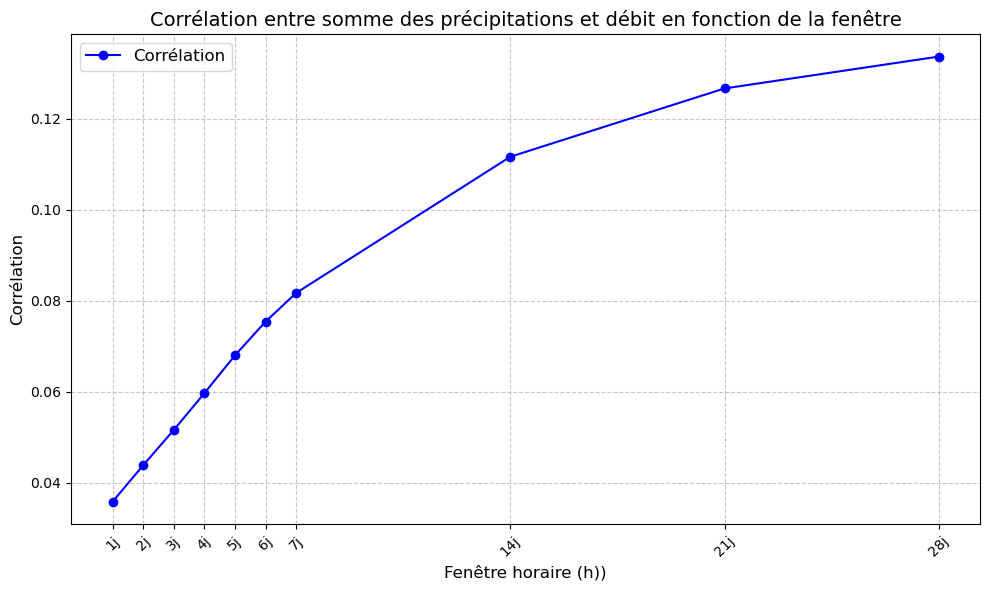

In [208]:
# Corrélation entre le débit et les précipitations sur une période donnée
windows = list(range(24, 6*24+1, 24)) + list(range(7*24, 4*7*24+1, 7*24)) # on définit la fenêtre journalière
correlations_RR1 = correlation2(result, column="RR1", target="debit", periods=windows)
plot_correlations(correlations_RR1, title="Corrélation entre somme des précipitations et débit en fonction de la fenêtre")

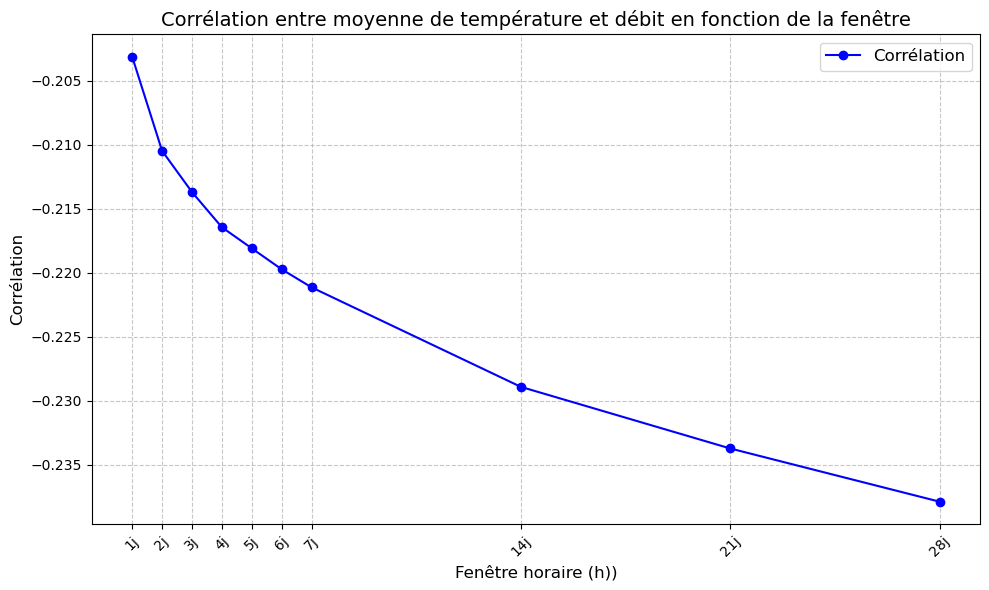

In [209]:
# Corrélation entre le débit et la température sur une période donnée
correlations_T = correlation2(result, column="T", target="debit", periods=windows)
plot_correlations(correlations_T, title="Corrélation entre moyenne de température et débit en fonction de la fenêtre")

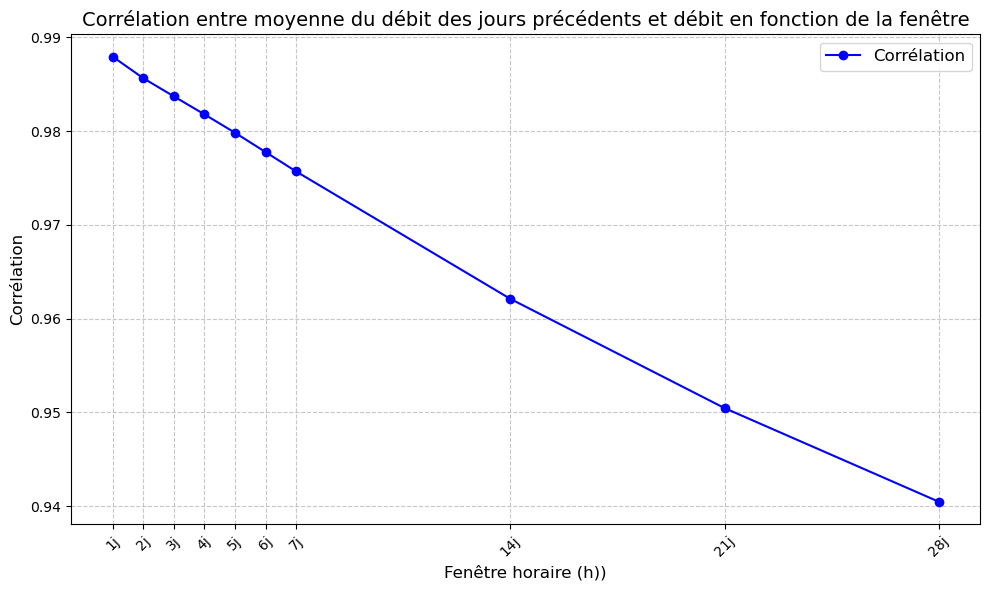

In [210]:
# Corrélation entre le débit et la température sur une période donnée
correlations_debit = correlation2(result, column="debit", target="debit", periods=windows)
plot_correlations(correlations_debit, title="Corrélation entre moyenne du débit des jours précédents et débit en fonction de la fenêtre")

Sous contrainte de données pour faire des prédictions effectives (30 jours) et par souci de réalisme, nous choisissons pour l'entraînement de retenir les données de débit du jour précédent, la moyenne des températures sur les 28 derniers jours et la somme des précipitations sur les 28 derniers jours également.

## 3.3 Création du modèle

Nous choisissons le modèle XGBRegressor, en le pensant particulièrement adapté pour des données complexes et des problèmes non linéaires, puisqu'il ne présuppose pas de relation linéaire entre les variables à prédire et les variables explicatives. Paramètres spécifiques utilisés : 
   
-n_estimators=200 : un bon compromis entre performance et temps de calcul, permet de limiter le temps d'exécution et de rester relativement robuste
   
-learning_rate=0.1 : taux d'apprentissage assez faible, permet d'éviter le surapprentissage
   
-max_depth=15 : implique d'avoir des sous-modèles assez complexes mais aussi de gagner en précision,
   
-subsample=0.8 et colsample_bytree=0.8 : définissent la fraction des échantillons et des colonnes utilisées pour chaque arbre, paramètres assez standardisés
   
-random_state=42 : assure la reproductibilité des résultats, ce qui est essentiel pour valider la fiabilité de l'approche.

-weigths sample : nous augmentons artificiellement énormément le poids de la latitude et de la longitude, puisque le débit dépend avant tout d'où sont situés les clubs.

En combinant ces réglages, ce modèle permet d'équilibrer précision, vitesse d'apprentissage et généralisation, ce qui est crucial pour prédire des variables influencées par des facteurs environnementaux multiples comme c'est le cas ici.

In [211]:
# Création des caractéristiques du modèle
result_train = create_features(result).copy()

# On supprime les lignes avec des valeurs manquantes dues aux décalages
result_train = result_train.dropna()

# Liste des variables explicatives
liste_variables_explicatives = ['LAT', 'LON', 'RR1', 'T', 'année', 'mois', 'jour', 'heure', 'RR1_sum_4w', 'T_mean_4w', 'debit_mean_1d']

# Définir les caractéristiques et la cible
features = [col for col in liste_variables_explicatives]
X = result_train[features]
y = result_train["debit"]

# Division entre l'ensemble train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création des poids d'échantillon : 5 pour LAT et LON, 1 pour les autres
sample_weights_train = [100 if (row['LAT'] != 0 and row['LON'] != 0) else 1 for _, row in X_train.iterrows()]

# Entrainement du modèle avec les poids d'échantillon
model = XGBRegressor(
    n_estimators=200,  # Nombre d'arbres
    learning_rate=0.1,  # Taux d'apprentissage
    max_depth=15,  # Profondeur maximale des arbres
    subsample=0.8,  # Fraction d'échantillons pour chaque arbre
    colsample_bytree=0.8,  # Fraction de colonnes utilisées par arbre
    random_state=42
)

# Utilisez les poids corrects (sample_weights_train)
model.fit(X_train, y_train, sample_weight=sample_weights_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluer le modèle
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Affichage des résultats
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


RMSE: 17.51
R²: 0.9971


On obtient un R² proche de 1 et une mean square error a relativiser (entre 10 et 30 selon les exécutions), ce qui est assez satisfaisant.

## 3.4 Prédiction

Notre modèle est voué à être utilisé par les membres des clubs d'aviron, donc les prédictions sont ajustables.
On demande à l'utilisateur du service de rentrer la date pour laquelle il souhaite avoir une prédiction du débit, ainsi que les conditions du bassin qu'il souhaite consulter. 

On récupère toutes les données qui vont permettre de faire la prédiction grâce à cette entrée :

In [212]:

# On demande à l'utilisateur de rentrer la date et l'heure sous la forme dd/MM/yyyy HH:mm et le nom du club
date_str = input("Vous souhaitez connaitre le débit dans les quelques prochains jours sur un bassin de long de la Seine ? Entrez la date et l'heure sous la forme dd/MM/yyyy HH:mm : ")
club = input("Entrez le nom du club d'aviron : ")

# Conversion de la chaîne de caractères en objet datetime
try:
    # L'entrée est bien une chaîne de caractères et la convertir en objet datetime
    date = datetime.strptime(date_str, "%d/%m/%Y %H:%M")
    
    # Extraction du jour, le mois, l'année, l'heure et les minutes
    day = date.day
    month = date.month
    year = date.year
    hour = date.hour
    minute = date.minute
    
    # Résultats
    print(f"Date et heure entrée : {date.strftime('%d-%m-%Y %H:%M')}")

    
except ValueError:
    print("La date et l'heure entrées sont invalides. Veuillez entrer la date au format dd/MM/yyyy HH:mm.")

# Vérifier si le club est dans la colonne "Club" du DataFrame
if club in clubs_hydro_meteo["Club"].values:
    print(f"Club d'aviron sélectionné : {club}")
else:
    # Afficher un message si le club n'est pas reconnu
    clubs_list = ", ".join(clubs_hydro_meteo["Club"].values)
    print(f"Le club n'est pas reconnu. Merci de choisir un club parmi : {clubs_list}")

Date et heure entrée : 02-01-2025 14:00
Club d'aviron sélectionné : Société Nautique de la Haute Seine


On construit le dataframe qui nous servira de base pour la prédiction liée à ce club et à son bassin en particulier, en téléchargeant via l'API d'hydro.eaufrance les données de débit des 30 derniers jours à la station hydrométrique la plus proche, et en récupérant les données météo de la station météo la plus proche pour la même période.

In [213]:
#Station hydrométrique la plus proche du club recherché
recherche = clubs_hydro_meteo[clubs_hydro_meteo['Club'].str.contains(club, case=False, na=False)]

# Afficher le NUM_NHS ou un message d'erreur
NUM_NHS_predict=recherche['NUM_NHS'].values[0] if not recherche.empty else "Club non trouvé."


#Période : les 30 derniers jours
debut = (datetime.now()-timedelta(30)).isoformat() 

url_API = "https://hubeau.eaufrance.fr/api/v1/hydrometrie/observations_tr.csv"
url = url_API+ f"?code_entite={NUM_NHS_predict}&grandeur_hydro=Q&size=10000&date_debut_obs={debut}"

try :
    # Récupération des donnéesen csv et conversaion en dataframe
    with urlopen(url) as response:
        debit_jours_precedents = pd.read_csv(response, sep=';')

    # Normalisation du dataframe
    debit_jours_precedents = debit_jours_precedents[['code_station', 'resultat_obs', 'date_obs']]
    debit_jours_precedents.rename(columns={"date_obs": "date_heure", "resultat_obs": "debit", "code_station": "NUM_NHS"}, inplace=True)
    debit_jours_precedents["date_heure"] = pd.to_datetime(debit_jours_precedents["date_heure"], utc=True).dt.tz_localize(None)  # Conversion date en DateTime
    debit_jours_precedents["debit"] = debit_jours_precedents["debit"] / 1000  # Conversion du débit en m³/s (actuellement en l/s)

    # Nouvelle colonne pour une valeur arrondie à l'heure pour calculer la moyenne du débit par heure
    debit_jours_precedents["AAAAMMJJHH"] = debit_jours_precedents["date_heure"].dt.floor("h")
    debit_jours_precedents = debit_jours_precedents.groupby(["NUM_NHS", "AAAAMMJJHH"], as_index=False)["debit"].mean()

    # Affichage du résultat
    print(debit_jours_precedents)

except Exception as e:
    # En cas d'erreur, afficher un message d'erreur
    print("Une erreur s'est produite lors de l'exécution du programme : ", str(e))
    print("La station hydrométrique proche de ce club ne fournit pas les données en temps réel.")
    print("Nous vous conseillons de regarder le débit pour l'Aviron Club de Villennes-Poissy, à la sortie de Paris.")
    print("Si votre club est situé en amont, le débit sera moindre. En aval, il sera plus important.")


        NUM_NHS          AAAAMMJJHH       debit
0    F490000104 2024-11-30 02:00:00  404.000000
1    F490000104 2024-11-30 03:00:00  401.000000
2    F490000104 2024-11-30 04:00:00  398.000000
3    F490000104 2024-11-30 05:00:00  398.100000
4    F490000104 2024-11-30 06:00:00  390.200000
..          ...                 ...         ...
715  F490000104 2024-12-29 21:00:00  418.833333
716  F490000104 2024-12-29 22:00:00  419.500000
717  F490000104 2024-12-29 23:00:00  420.333333
718  F490000104 2024-12-30 00:00:00  422.000000
719  F490000104 2024-12-30 01:00:00  421.600000

[720 rows x 3 columns]


In [214]:
# 1: On sélectionne le sous-dataframe de données de débit horaire correspondant
debit_club_pred = pd.merge(debit_jours_precedents, clubs_hydro_meteo[['Club', 'LAT', 'LON', 'NUM_NHS', 'NHS']], on='NUM_NHS', how='left')
debit_club_pred = debit_club_pred[debit_club_pred['Club'] == club]

In [215]:
# 2: on joint les données de meteo_horaire_pred avec clubs_hydro_meteo sur NUM_NWS
meteo_club_pred = meteo_horaire_pred.merge(
    clubs_hydro_meteo[['Club', 'LAT', 'LON', 'NUM_NWS', 'NWS']],
    left_on='NUM_POSTE',
    right_on='NUM_NWS',
    how='inner'
)

In [216]:
# 3: on combine les deux DataFrames sur le Club et la colonne temporelle 'AAAAMJJHH'
debit_meteo_combined_pred = debit_club_pred.merge(
    meteo_club_pred,
    on=['Club', 'AAAAMMJJHH'],
    suffixes=('_hydro', '_meteo')
)

In [217]:
# 4: on sélectionne les colonnes pertinentes et on copie le dataframe pour éviter les intéractions fâcheuses
debit_meteo_combined_predict = debit_meteo_combined_pred[['Club', 'LAT', 'LON','AAAAMMJJHH', 'debit', 'RR1', 'T']].copy()

# Et on normalise le dataframe afin de le rendre prêt pour la modélisation
# On s'assure que toutes les valeurs sont numériques
debit_meteo_combined_predict["debit"] = pd.to_numeric(debit_meteo_combined_predict["debit"], errors="coerce")
debit_meteo_combined_predict["LAT"] = pd.to_numeric(debit_meteo_combined_predict["LAT"], errors="coerce")
debit_meteo_combined_predict["LON"] = pd.to_numeric(debit_meteo_combined_predict["LON"], errors="coerce")
debit_meteo_combined_predict = debit_meteo_combined_predict.dropna(subset=["debit", "RR1", "T"])

# On extrait les caractéristiques temporelles 
debit_meteo_combined_predict["année"] = debit_meteo_combined_predict["AAAAMMJJHH"].dt.year
debit_meteo_combined_predict["mois"] = debit_meteo_combined_predict["AAAAMMJJHH"].dt.month
debit_meteo_combined_predict["jour"] = debit_meteo_combined_predict["AAAAMMJJHH"].dt.day
debit_meteo_combined_predict["heure"] = debit_meteo_combined_predict["AAAAMMJJHH"].dt.hour

# Supprimer la colonne datetime originale si elle n'est plus utile
debit_meteo_combined_predict = debit_meteo_combined_predict.drop(columns=["AAAAMMJJHH"])
debit_meteo_combined_predict

#On ajoute les variables explicatives
debit_meteo_combined_predict=create_features(debit_meteo_combined_predict)

On peut maintenant procéder à la prédiction : 

In [218]:
#On choisit les variables explicatives de meme que dans l'entrainement du modèle
features_pred = [col_pred for col_pred in debit_meteo_combined_predict.columns if col_pred not in ["datetime", "Club", "debit"]]
X_pred = debit_meteo_combined_predict[features_pred]
prediction = model.predict(X_pred)


#Resultat
resultat_prediction = prediction[0]
resultat_prediction = int(resultat_prediction)


Voilà la sortie pour l'utilisateur : 

In [219]:
phrase = f"Le débit prédit pour le {date} avoisine les {resultat_prediction:.2f} m³/s. "

# Ajout des recommandations en fonction du débit
if 550 <= resultat_prediction <= 750:
    phrase += (
        "Le débit est assez fort. Nous vous recommandons vivement de ne pas sortir en bateau individuel, pour votre sécurité. " 
    )
elif resultat_prediction > 750:
    phrase += (
        "Attention : le débit est extrêmement élevé. Toute sortie sur l'eau est formellement interdite pour votre sécurité. " 
    )
else:
    phrase += (
        "Les conditions sont idéales ! Vous pouvez profiter sereinement de votre sortie sur l'eau. "
    )

# Affichage de la réponse complète
display(Markdown(phrase))


Le débit prédit pour le 2025-01-02 14:00:00 avoisine les 758.00 m³/s. Attention : le débit est extrêmement élevé. Toute sortie sur l'eau est formellement interdite pour votre sécurité. 

# Conclusion
Le modèle pourrait être étendu et utilisé par tous les clubs d'aviron, à condition d'une mise à disposition plus aisée de la base des données de débit aux stations hydrométriques. En effet,  data.gouv propose deux manières d'accéder aux données hydrométriques : 
1. une API accessible par URL, permettant d'avoir accès à toutes les données de débit en France mais uniquement sur les 30 derniers jours
2. des archives des données hydrométriques, accessibles uniquement par téléchargement manuel pour chaque station hydrométrique d'intérêt. 

Afin de ne pas perdre de temps à télécharger des centaines de bases de données hydrométriques nous avons donc choisi de restreindre notre modèle à la Seine. 

Quelques pistes d'amélioration peuvent être envisagées : trouver le nombre maximal de jours en dessous duquel la prédiction reste à peu près fiable, donner un plus grand poids à la localisation du club d'aviron dans le modèle (tendance à surestimer le débit en amont de la Seine),  créer une vraie interface utilisateur, ou encore affiner notre modèle avec des données géographiques comme les géométries de bassin (reliefs, goulots d'écoulement). Une nuance est à apporter d'ailleurs entre débit et courant : dans le monde de l'aviron, on utilise uniquement de débit, mais pour plus de justesse on devrait utiliser la notion de courant (débit x volume).